### **Data Set**

In this homework we would like you to be sophisticated: The dataset we want you to
work on is the wine quality dataset, containing a set of collected features for each wine
and a rank of that wine as found by ’wine experts’ on the scale of 1 to 10.
You can also find this dataset in the Tensorflow Datasets Collection , however, as tfds
has been proven to be a bit difficult at times, this week we would like you to create your
own Tensoflow Dataset from a .csv using pandas 1
. Do not worry, this is very easy!

**1.1 Load Data into a Dataframe**

You can download the .csv and store it on your local computer or directly read in the
url when working with pandas. Read the data into a pandas dataframe. 2
1
Wine Quality Dataset: https://archive.ics.uci.edu/ml/
machine-learning-databases/wine-quality/winequality-red.csv
Make yourself familiar with the dataset.
• What keys are there?
• What should be the input and what should be the target for our NN? 3

**1.2 Create a Tensorflow Dataset and a Dataset Pipeline**

Split the dataset into a train, test and validation split. 4
Separate the labels from the input and store them accordingly. 5
Out of the resulting dataframes, build a Tensorflow Dataset.
6
Now we want to make this a Binary Classification Task: As we are not as sophisticated as our wine experts, we only care about good wine vs. bad wine. Write a function
make binary(target) that receives a target and returns a target fit for a binary classification task. 7 You can hardcode (i.e. fix) a threshold or use statistics obtained from
your data, e.g. the median ranking of all wines.8
Create a Data Pipeline with all the necessary steps. You should at least map the
make binary() function to the dataset and apply batching.


1. Don’t forget to import pandas! Usually, ’import pandas as pd is used, thus in the future we will
refer to pandas with pd
2. Check out pd.readcsv()and think about how to set the delimiter argument 14
3. The column ’quality’ contains the respective targets to the feature vector specified by all previous
columns i.e. each point of the dataset should have 11 values (fixed acidity, volatile acidity,...) and one
target (quality).
4. check out df.sample(frac=, randomstate =) and df.drop()
5. check out pandas df.drop( ,axis=)
6. again check out tf.data.Dataset.fromtensorslices()
7. this function should compare the rank to some threshold and return a 0 for bad and a 1 for good wine
8. if you use the mean, you may notice that your dataset becomes extremely imbalanced




In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np


url="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

df=pd.read_csv(filepath_or_buffer = url, sep  =";")
df.head(10)
# Index(['fixed acidity', 'volatile acidity', 'citric acid', 
#                             'residual sugar', 'chlorides', 'free sulfur dioxide',
#                             'total sulfur dioxide', 'density', 'pH', 'sulphates', 
#                             'alcohol', 'quality'],  dtype='object')

# features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
#             'chlorides', 'free sulfur dioxide','total sulfur dioxide', 'density',
#             'pH', 'sulphates','alcohol']
# label = "quality"

# features = list(df[df.columns[:-1].values])
# print(features)
# label = df["quality"]
# print(label)



# train 60%, test 20%, validation 20%

# train =  df.sample(frac=0.6, random_state=0)
# df = 
# test = df.sample(frac=0.2, random_state=1)
# validation = df.sample(frac=0.2, random_state=2)



#take = 959, 319, 319
 



dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(df[df.columns[:-1]].values, tf.float64),tf.cast(df['quality'].values, tf.float64))))
full_ds = dataset

full_size = len(df)

train_size = int(0.8 * full_size)
valid_size = int(0.1 * full_size)








def make_binary(target): 
  thrashold = df["quality"].median()
  if (target >=  thrashold):

    return 1
  else: 
    return 0





def preprocess(data):
    data = data.map(lambda x, y: (x, [make_binary(y)]))
    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(8)
    data = data.prefetch(20)
    return data


train_dataset = preprocess(full_ds.take(train_size))
remaining = full_ds.skip(train_size)  
valid_dataset = preprocess(remaining.take(valid_size))
test_dataset = preprocess(remaining.skip(valid_size))



# train_ds = train.apply(build_pipeline)
# test_ds = test.apply(build_pipeline)
# validation_ds = validation.apply(build_pipeline)











### 2 Model
You can pretty much recycle the model you defined for last week’s task with some small
modifications.
• As the task is maybe a bit simpler and you are aiming to explore the effect of
optimization techniques, also try to make your model a bit smaller. The baseline
model should barely be able to perform sufficiently good at the task (better than
random).
• As we now are dealing with a binary classification task, you have to change the
configuration of the output layer. 9

9. you only need 1 output neuron and you should use something like a sigmoid as an activation function. 


In [2]:
import tensorflow as tf
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L1(0.01),
                                            activity_regularizer=tf.keras.regularizers.L2(0.01))
        
        self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L1(0.01),
                                            activity_regularizer=tf.keras.regularizers.L2(0.01))
        
        self.output_layer = tf.keras.layers.Dense(1, activation= tf.nn.sigmoid)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.output_layer(x)
        return x
        
# for regularization 
# https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer


# tf.keras.regularizers.L1(0.3)  # L1 Regularization Penalty
# tf.keras.regularizers.L2(0.1)  # L2 Regularization Penalty
# tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)  # L1 + L2 penalties


# Custom Layer
class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units=8):
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = tf.nn.softmax

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

### 3 Training
Then start by training your network for 10 epochs using a learning rate of 0.1. You
can again copy most of the training procedure from last week. However, you have to
change the loss function to fit our binary task! 10. For the beginning try using SGD as
an optimizer.

Also, when computing the accuracy, slight changes are required to transfer to the
binary task. 11


10. Have a look at tf.keras.losses.BinaryCrossentropy()
11. instead of np.argmax() think about using np.round(,0)

In [3]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)

     # need to use np.round(,0)
    #sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)

    # target is a single value do lwe need argmax ?? 
    sample_test_accuracy =  np.argmax(target, axis=1) == np.round(prediction, 0)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy







### 4 Fine-Tuning
Now comes the fun part. Your task is to apply at least 3 optimization and regularization
techniques featured in the lecture with the goal to significantly increase your model’s
performance. 12
You can also think about another approach and normalize the input data. 13
In the end, everything is up to you! You should witness an increase in performance,
stability, and generalization.
You may notice that some optimization techniques such as dropout seem to rather
decrease performance. However, please bear in mind that these techniques often address
ensuring better generalization. So before you start going all out on the test set, don’t
forget what the validation set is for.

12. If you are using Dropout, think about the flag training= that you can pass onto the call of Dropout.

13. For that the stats returned by pandas df.describe() could prove useful to you

In [4]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
# train_dataset = train_dataset.take(1000)
# test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

# for binary croos entropy
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()


# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)
# optimizer =tf.keras.optimizers.RMSprop(learning_rate , centered = False)
# optimizer = tf.keras.optimizers.Adam(learning_rate )
# optimizer = tf.keras.optimizers.Adagrad(learning_rate )

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
#test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_loss, test_accuracy = test(model, test_dataset, binary_cross_entropy)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, binary_cross_entropy)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, binary_cross_entropy, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, binary_cross_entropy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch: 0 starting with accuracy 0.0
Epoch: 1 starting with accuracy 0.27380952380952384
Epoch: 2 starting with accuracy 0.6309523809523809
Epoch: 3 starting with accuracy 0.09523809523809523
Epoch: 4 starting with accuracy 0.2916666666666667
Epoch: 5 starting with accuracy 0.18452380952380953
Epoch: 6 starting with accuracy 0.1488095238095238
Epoch: 7 starting with accuracy 0.19642857142857142
Epoch: 8 starting with accuracy 0.49404761904761907
Epoch: 9 starting with accuracy 0.22023809523809523


### 5 Visualization
Visualize accuracy and loss for training and test data using matplotlib.

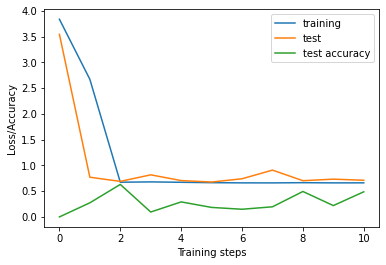

In [5]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()